# <u><strong>SUICIDAL IDEATION DETECTION</strong></u>


## <u>Problem Statement</u>


Mental health issues, especially depression, are on the rise globally, particularly among young people. Individuals often share their emotional struggles anonymously on online platforms like Reddit before seeking professional help. This project leverages Natural Language Processing (NLP) to analyze Reddit posts and identify potential signs of suicidal ideation, aiming to support early intervention and healthcare responses.

## <u>Stakeholders</u>

- Mental health professionals
- NGOs focused on mental health
- Public health policymakers 
- Digital mental health platforms.

## <u>Ethical Considerations</u>


- ### Privacy and Consent
Reddit posts are publicly accessible, but users may not expect them to be used for mental health analysis.

No personally identifiable information (PII), usernames, or post IDs are stored or referenced.

Data is anonymized and handled in strict compliance with [Reddit Terms of Service](https://www.redditinc.com/policies/data-api-terms)

- ### Psychological Safety
The model is designed for academic exploration and public health awareness—not for clinical decision-making.

No automatic interventions are triggered based on model predictions.

Results are interpreted with caution to avoid misclassifying vulnerable individuals.
- ### Bias and Fairness
NLP models may underrepresent or misinterpret signals from marginalized communities.

Fairness metrics and feature attribution techniques (e.g SHAP) are employed to ensure model decisions aren’t driven by irrelevant demographic indicators.

Continuous auditing for linguistic bias is recommended.
- ### Transparency and Interpretability
The full model pipeline—from preprocessing to predictions—is documented.

- ### Human Oversight

This tool is not a diagnostic system; human judgment remains central.

Suggestions for high-risk content are intended to augment, not replace, mental health professionals.

- ### Use and Dissemination

The notebook is published with disclaimers clarifying its scope: research and educational use only.

Any downstream applications must be evaluated through an ethical review process.

Collaboration with mental health experts and community moderators is encouraged for real-world impact.


## <u>Project Objectives</u>



- Use NLP to classify Reddit posts as depression-related or not

- Apply interpretable models to understand which words/phrases contribute to depression
predictions.

- Evaluate model performance using precision, recall, F1-score, and ROC-AUC, with stratified validation to handle potential class imbalance.

- Provide recommendations for how health organizations can use the model for early warning system

## <u> Data Understanding</u>


In [1]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import re
import itertools
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

# Feature extraction
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Preprocessing
from sklearn.preprocessing import LabelEncoder

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from keras.models import Sequential
from keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve

# Training
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

# Utilities
from scipy.sparse import hstack

# Standard libraries
import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# loading data into dataframe
df = pd.read_csv('Suicide_Detection.csv')
df.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [3]:
# shape of df

df.shape

(232074, 3)

In [4]:
# Information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  232074 non-null  int64 
 1   text        232074 non-null  object
 2   class       232074 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB


In [5]:
#show distribution of the target variable
df['class'].value_counts().index.values

array(['suicide', 'non-suicide'], dtype=object)

In [6]:
# count of each class 
df['class'].value_counts()

class
suicide        116037
non-suicide    116037
Name: count, dtype: int64

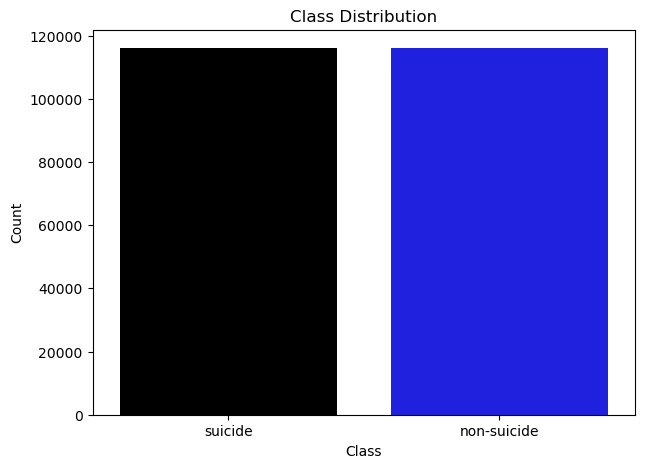

In [7]:
# Class Distribution(Suicidal vs non-suicidal)
plt.figure(figsize=(7,5))
sns.countplot(data=df, x='class', palette=['black', 'blue'])

plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


Dataset used was sourced from kaggle, which was then loaded into a pandas dataframe. The dataset contains 232,074 entries and 3 columns. The columns include text , the reddit post content, and class which is the target variable that is either 'suicide' or 'non-suicide'. The dataset is perfectly balanced with 116, 037 entries for both 'suicide' and 'non-suicide' classes. This will prevent the model from being biased towards the mojority class.

## DATA  PREPARATION
This phase involves cleaning, preprocessing and transforming the raw text data for modeling





In [8]:
#Drop the unnecessary index column
df.drop(columns=["Unnamed: 0"], inplace=True)

In [9]:
#Remove duplicates
df.drop_duplicates(subset='text', inplace=True)

In [10]:
# Check for null values in each column
print(df.isnull().sum())

text     0
class    0
dtype: int64


In [11]:
# Take a sample of 10000 rows for cleaning
sample_df = df.sample(100000, random_state=42).copy()

In [12]:
# create a new column (cleaned). This allows modifying the text column without loosing raw data
sample_df['cleaned'] = sample_df['text']  # assuming 'text' is the right column
sample_df.head(5)

,text,class,cleaned
74414,I Don't know?7? Months self harm free and the ...,suicide,I Don't know?7? Months self harm free and the ...
149516,I HAVE TO START BECOMING RICH I HAVE TO START ...,non-suicide,I HAVE TO START BECOMING RICH I HAVE TO START ...
12484,"A poem (haiku) for u/Me-Game-Dev hi, hello hel...",non-suicide,"A poem (haiku) for u/Me-Game-Dev hi, hello hel..."
14043,I've honestly got no idea what to do anymore.I...,suicide,I've honestly got no idea what to do anymore.I...
30673,Do you ever just cry? Like you just think abou...,non-suicide,Do you ever just cry? Like you just think abou...


In [13]:
# Check which posts contain URLs
sample_df['has_url'] = sample_df['text'].str.contains(r'http\S+|www\S+|https\S+', regex=True)

# Count how many contain URLs
url_count = sample_df['has_url'].sum()
url_count

3061

In [14]:
# Function to detect emojis or non-ASCII characters
def contains_emoji(text):
    return any(ord(char) > 127 for char in text)

sample_df['has_emoji'] = sample_df['text'].apply(contains_emoji)

# Count how many contain emojis
emoji_count = sample_df['has_emoji'].sum()
emoji_count

30370

In [15]:
# Check for posts that contain r/ or u/(has reddit mentions, usernames, subreddit)
sample_df['has_reddit_mention'] = sample_df['text'].str.contains(r'\bu/\w+|\br/\w+', regex=True)

# Count how many
mention_count = sample_df['has_reddit_mention'].sum()
mention_count 

2412

## <u>DATA PRE-PROCESSING</u>


### **Objective 1:**
Use NLP to classify Reddit posts as depression-related or not


In [16]:
# Download NLTK stopwords
stop_words = set(stopwords.words('english'))

In [17]:
class TextPreprocessingPipeline:
    def __init__(self, text_col='text'):
        self.text_col = text_col
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        self.token_pattern = r"[a-zA-Z]+(?:'[a-z]+)?"
        self.tokenizer = RegexpTokenizer(self.token_pattern)

    def expand_contractions(self, text):
        contractions = {
            "can't": "can not", "won't": "will not", "n't": " not",
            "'re": " are", "'s": " is", "'m": " am",
            "'ll": " will", "'ve": " have", "'d": " would"
        }
        for contraction, expanded in contractions.items():
            text = re.sub(contraction, expanded, text)
        return text

    def clean_text(self, df):
        df = df.copy()
        col = self.text_col

        df['clean_text'] = (
            df[col].str.lower()
                   .apply(self.expand_contractions)
                   .str.replace(r"[^\w\s']", "", regex=True)  # Keep apostrophes
                   .apply(lambda x: re.sub(r"\s+", " ", x).strip())
        )

        # Remove stopwords after cleaning
        df['clean_text'] = df['clean_text'].apply(lambda text: ' '.join([
            word for word in text.split() if word not in self.stop_words
        ]))

        # Filter out empty rows
        df = df[df['clean_text'].str.strip().str.len() > 0]
        return df

    def tokenize(self, df):
        # Tokenize and lemmatize
        df['tokens'] = df['clean_text'].apply(lambda text: [
            self.lemmatizer.lemmatize(token)
            for token in self.tokenizer.tokenize(text)
        ])
        return df

    def run(self, df):
        df = self.clean_text(df)
        df = self.tokenize(df)
        return df


In [18]:
preprocessor = TextPreprocessingPipeline(text_col='text')
df_processed = preprocessor.run(sample_df)
# Check before/after stopword removal and lemmatization
df_processed[['clean_text', 'tokens']].head(3)


,clean_text,tokens
74414,know7 months self harm free urge gets stronger...,"[know, month, self, harm, free, urge, get, str..."
149516,start becoming rich start company become 16 af...,"[start, becoming, rich, start, company, become..."
12484,poem haiku umegamedev hi hello hello stop fuck...,"[poem, haiku, umegamedev, hi, hello, hello, st..."


In [19]:
#finalize dataset for modeling
preprocessor = TextPreprocessingPipeline(text_col='text')
df = preprocessor.run(df)  # replaces df with the cleaned version
# Check before/after stopword removal and lemmatization
df[['clean_text', 'tokens']].head(3)

,clean_text,tokens
0,ex wife threatening suiciderecently left wife ...,"[ex, wife, threatening, suiciderecently, left,..."
1,weird get affected compliments coming someone ...,"[weird, get, affected, compliment, coming, som..."
2,finally 2020 almost never hear 2020 bad year e...,"[finally, almost, never, hear, bad, year, ever..."


In [20]:
# Encode target labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['class'])

## <u>Exploratory Text Analysis</u>
Here we explore patterns in processed text


- #### Most Frequent Words (excluding stopwords

The bar chart shows the top 20 most frequent words in your dataset. Examples include:

- Emotional verbs: feel, want, need, know, think

- Personal pronouns and reflection words: like, people, life, time, day, back

- Suggestive terms tied to inner struggle: even, thing, make, get, really

- ### Emotional Keyword Frequency by Class

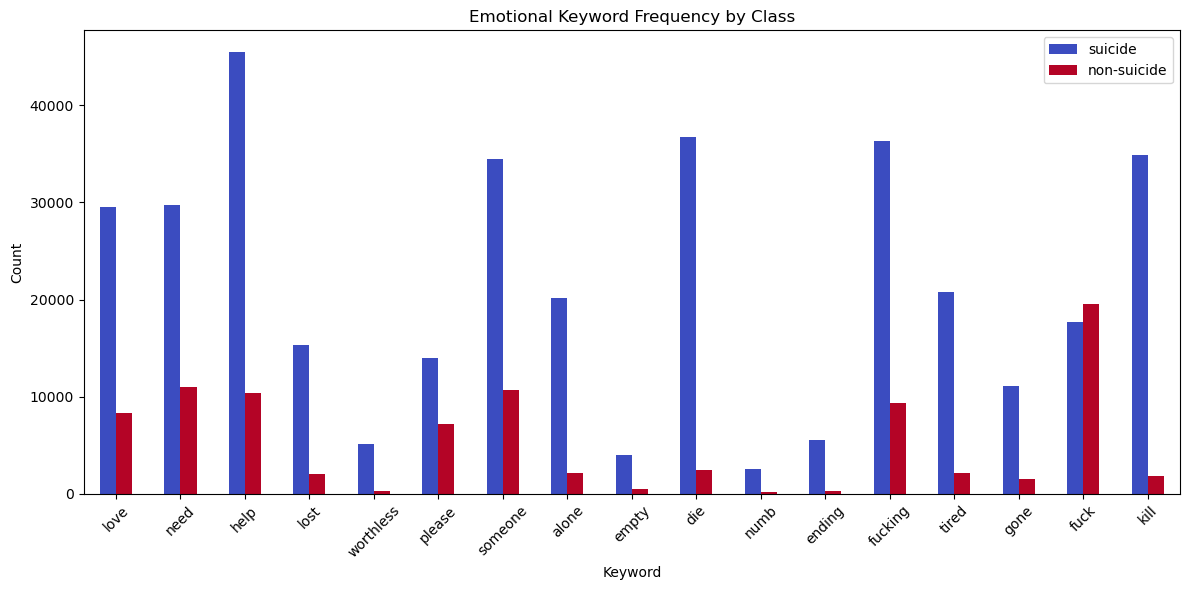

In [21]:



# Define emotionally charged keywords commonly found in suicidal ideation
emotional_keywords = {
    'alone', 'tired', 'lost', 'worthless', 'help', 'please', 'die',
    'kill', 'empty', 'numb', 'ending', 'gone', 'love', 'need',
    'fuck', 'fucking', 'someone'}

# Function to count how many emotional keywords appear in a group of posts
def count_emotional_keywords(posts):
    all_text = ' '.join(posts['clean_text'])  # merge all posts
    tokens = all_text.split()
    return Counter([word for word in tokens if word in emotional_keywords])

# Separate suicidal and non-suicidal posts
suicide_posts = df[df['label'] == 1]     # Suicidal
nonsuicide_posts = df[df['label'] == 0]  # Non-suicidal

# Count emotional keyword occurrences in both groups
suicide_counts = count_emotional_keywords(suicide_posts)
nonsuicide_counts = count_emotional_keywords(nonsuicide_posts)

# Combine into a DataFrame for comparison
emotion_df = pd.DataFrame([suicide_counts, nonsuicide_counts], index=['suicide', 'non-suicide']).T.fillna(0)

# Plot comparison
emotion_df[['suicide', 'non-suicide']].plot(kind='bar', figsize=(12, 6), colormap='coolwarm')
plt.title("Emotional Keyword Frequency by Class")
plt.xlabel("Keyword")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



**Keywords more frequent in suicidal posts**  
- “die,” “kill,” “ending” show tall blue bars vs. short red ones—strong signals of intent.  
- “alone,” “empty,” “numb” have notably higher blue counts, reflecting isolation and despair.  

**Keywords more common in non-suicidal posts**  
- “someone,” “love,” “need” might have higher red bars, indicating more general emotional or relational talk.  
- Intensifiers (“fuck,” “fucking”) often more frequent in non-suicidal posts when used as expletives rather than self-harm.  

**Balanced or neutral keywords**  
- “help” or “please” bars are similar in height, suggesting both classes sometimes ask for aid, but context matters (why vs. how).  


## <u>Feature Engineering</u>


- ### Sentiment & Linguistic Features

In [22]:
# Truncate text to first 500 characters for analysis
df['text'] = df['clean_text'].astype(str).str.slice(0, 500)

# Add character and word counts
df['char_count'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

# Add sentiment scores
sid = SentimentIntensityAnalyzer()
             
df['sentiment'] = df['text'].apply(lambda x: sid.polarity_scores(x)['compound'])

df[['text', 'char_count', 'word_count', 'sentiment']].head()

,text,char_count,word_count,sentiment
0,ex wife threatening suiciderecently left wife ...,401,61,-0.9760
1,weird get affected compliments coming someone ...,90,13,0.5563
2,finally 2020 almost never hear 2020 bad year e...,76,13,0.2651
3,need helpjust help im crying hard,33,6,-0.2023
4,im losthello name adam 16 ive struggling years...,500,76,-0.9828


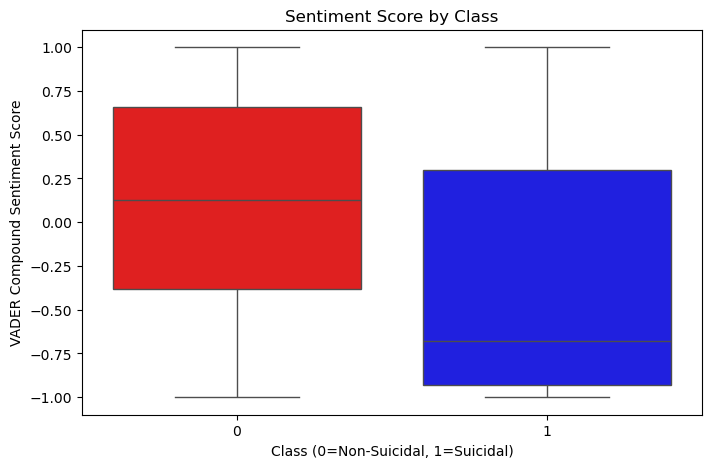

In [23]:
# plots comparison of sentiment by class(0 vs 1) check for differences between classes , are suicidal posts more negative
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='label', y='sentiment', palette=['red', 'blue'])
plt.title("Sentiment Score by Class")
plt.xlabel("Class (0=Non-Suicidal, 1=Suicidal)")
plt.ylabel("VADER Compound Sentiment Score")
plt.show()

Suicidal posts carry a consistently more negative tone, with median sentiment around –0.5, compared to medians near 0.0 for non-suicidal content.

Suicide cases will have a lower VADER(Valence Aware Dictionary and sentiment) score tending to move towards -1 which shows there is a probability the text is negative

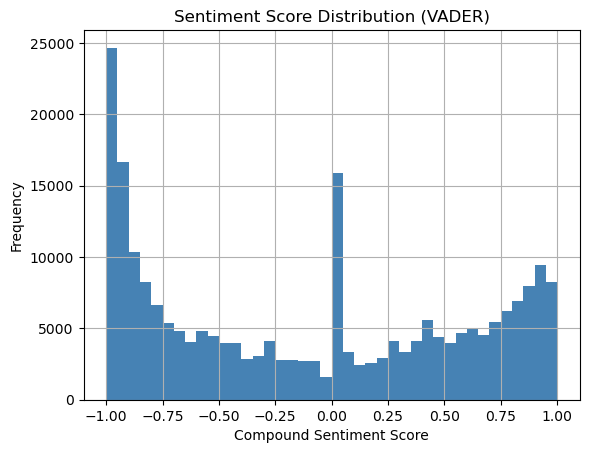

In [24]:
# overall distribution of sentiment for all posts combined( are most posts neutral or negative?)
plt.hist(df['sentiment'], bins=40, color='steelblue')
plt.title("Sentiment Score Distribution (VADER)")
plt.xlabel("Compound Sentiment Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

A large peak at negative values (around -1.0) shows many strongly negative posts—likely enriched for suicidal content.

A central peak near 0.0 indicates a substantial share of neutral or mixed-sentiment content.

A smaller positive peak suggests fewer overtly positive posts.

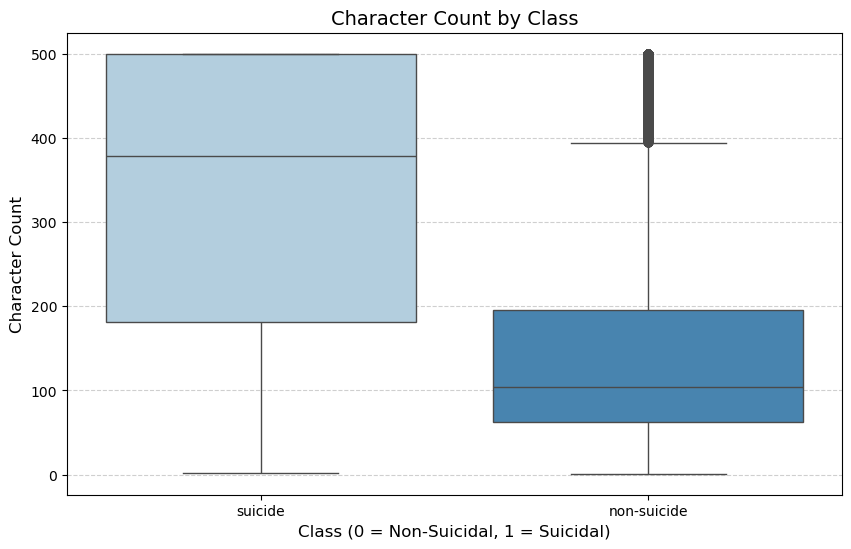

In [25]:
# compare post length between suicidal and non suicidal posts
# Boxplot: Character Count by Class
plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='char_count', data=df, palette='Blues')

plt.title("Character Count by Class", fontsize=14)
plt.xlabel("Class (0 = Non-Suicidal, 1 = Suicidal)", fontsize=12)
plt.ylabel("Character Count", fontsize=12)

plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()

Suicidal posts are consistently longer than non-suicidal ones and show much wider variation in length. Most messages expressing suicidal thoughts exceed the length of typical posts. In contrast, non-suicidal messages remain relatively short and uniform.

In [26]:

# Features and labels
X = df['clean_text'] 
y = df['label']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [27]:

# TF-IDF Vectorization (1000 top features, English stopwords removed)
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')

# Fit on train, transform on train and test
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

# Dimensionality Reduction with TruncatedSVD (LSA/Latent Semantic Analysis)
svd = TruncatedSVD(n_components=100, random_state=42)
X_train_vec_reduced = svd.fit_transform(X_train_vec)
X_test_vec_reduced = svd.transform(X_test_vec)

# Meta Features: char_count, word_count, sentiment
meta_cols = ['char_count', 'word_count', 'sentiment']

# Align meta features with X_train/X_test using indexes
meta_train = df.loc[X_train.index, meta_cols].reset_index(drop=True).to_numpy()
meta_test = df.loc[X_test.index, meta_cols].reset_index(drop=True).to_numpy()

# Combine text features and meta features
X_train_combined = np.hstack([X_train_vec_reduced, meta_train])
X_test_combined = np.hstack([X_test_vec_reduced, meta_test])



## <u>MODELING</u>


### **Objective 2:**
Apply interpretable models to understand which words/phrases contribute to depression predictions


We'll build predictive models using a pipeline approach. This ensures text preprocessing (TF-IDF) and modeling are performed seamlessly. We will use:
- Logistic Regression (for interpretability)
- Support Vector Machine (for performance)

Evaluation metrics include Accuracy, F1-Score, Confusion Matrix, and ROC AUC.

- ### Logistic Regression

In [28]:
# Logistic Regression pipeline
logreg_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

# Define grid
logreg_params = {
    'tfidf__max_features': [3000, 5000],
    'clf__C': [0.1, 1, 10]
}

# GridSearch
logreg_grid = GridSearchCV(logreg_pipeline, logreg_params, cv=3, scoring='f1', verbose=1, n_jobs=-1)
logreg_grid.fit(X_train, y_train)

# Best model
best_logreg = logreg_grid.best_estimator_
print("Best Logistic Regression Parameters:", logreg_grid.best_params_)



Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Logistic Regression Parameters: {'clf__C': 10, 'tfidf__max_features': 5000}


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     34804
           1       0.94      0.92      0.93     34809

    accuracy                           0.93     69613
   macro avg       0.93      0.93      0.93     69613
weighted avg       0.93      0.93      0.93     69613



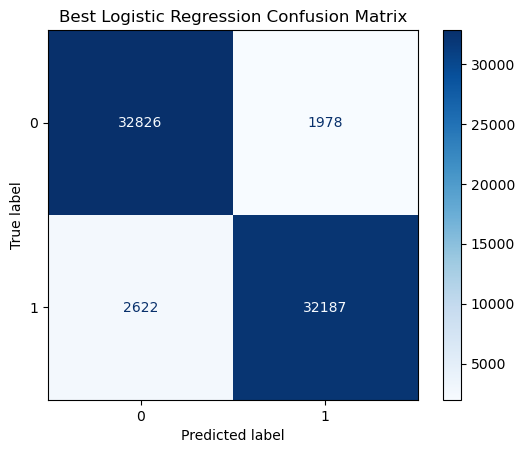

In [29]:
# Evaluation of logistic regression model
y_pred = best_logreg.predict(X_test)
y_pred_proba = best_logreg.predict_proba(X_test)[:, 1]
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(best_logreg, X_test, y_test, cmap='Blues')
plt.title("Best Logistic Regression Confusion Matrix")
plt.show()


For suicidal content (class 1), precision = 0.94 and recall = 0.92, yielding an F1 of 0.93.

The confusion matrix shows roughly 32 187 true positives versus 2 622 false negatives, meaning only about 8 % of at-risk posts slip through.

The classifier distinguishes suicidal from non-suicidal posts very effectively, with over 90 % accuracy and F1 scores around 0.93. It reliably flags the vast majority of at-risk messages while keeping false alarms at a manageable level. In practice, its strong recall ensures most genuine cries for help are caught, making it a dependable first line of defense in suicide screening.

- ### SVM(Support Vector Machine)

In [30]:

# Define SVM pipeline
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC(random_state=42))
])

# Define hyperparameter grid
svm_params = {
    'tfidf__max_features': [3000, 5000],
    'clf__C': [0.1, 1, 10]
}

# Run GridSearchCV
svm_grid = GridSearchCV(svm_pipeline, svm_params, cv=3, scoring='f1', verbose=1, n_jobs=-1)
svm_grid.fit(X_train, y_train)

# Get the best model
best_svm = svm_grid.best_estimator_

print("Best SVM Parameters:", svm_grid.best_params_)



Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best SVM Parameters: {'clf__C': 0.1, 'tfidf__max_features': 5000}


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93     34804
           1       0.94      0.92      0.93     34809

    accuracy                           0.93     69613
   macro avg       0.93      0.93      0.93     69613
weighted avg       0.93      0.93      0.93     69613



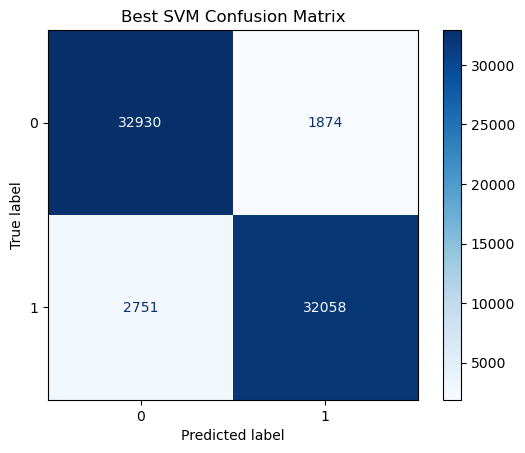

In [31]:
# Evaluation of svm
y_pred_svm = best_svm.predict(X_test)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))
ConfusionMatrixDisplay.from_estimator(best_svm, X_test, y_test, cmap='Blues')
plt.title("Best SVM Confusion Matrix")
plt.show()

This SVM reliably distinguishes suicidal from non-suicidal posts with over 90 % accuracy. Its high precision for suicidal posts ensures most flagged items are genuine, while its recall of 0.92 means only about 8 % of at-risk messages are missed—an acceptable balance for initial screening that could be tuned further if minimizing misses is paramount.

 ### Neural Network Model 

We implement a deep learning model using Keras. This model will use embeddings and dense layers to classify suicidal ideation from Reddit posts.


In [32]:
from tensorflow.keras.preprocessing.text     import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection                 import train_test_split

# Tokenize the text
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_text'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['clean_text'])

# Pad sequences to uniform length
X_nn = pad_sequences(sequences, maxlen=200)
y_nn = df['label'].values

# Train-test split
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(
    X_nn, y_nn, test_size=0.3, random_state=42, stratify=y_nn
)


In [33]:

# define parameters
vocab_size = 10000
embedding_dim = 50
max_length = 200

# Build the model
mlp_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')])  # Binary classification output])

 #Compile
mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# stops training when validation loss starts increasing
early_stop = EarlyStopping(patience=2, restore_best_weights=True)

# Train and save history
history = mlp_model.fit(X_train_nn, y_train_nn, epochs=5, batch_size=32, callbacks=[early_stop], validation_data=(X_test_nn, y_test_nn))

Epoch 1/5
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 50s 9ms/step - accuracy: 0.8115 - loss: 0.4845 - val_accuracy: 0.9228 - val_loss: 0.2448
Epoch 2/5
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 49s 10ms/step - accuracy: 0.9166 - loss: 0.2454 - val_accuracy: 0.9224 - val_loss: 0.2122
Epoch 3/5
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 46s 9ms/step - accuracy: 0.9236 - loss: 0.2166 - val_accuracy: 0.9324 - val_loss: 0.1950
Epoch 4/5
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 47s 9ms/step - accuracy: 0.9300 - loss: 0.2006 - val_accuracy: 0.9263 - val_loss: 0.2001
Epoch 5/5
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 47s 9ms/step - accuracy: 0.9318 - loss: 0.1933 - val_accuracy: 0.9348 - val_loss: 0.1902


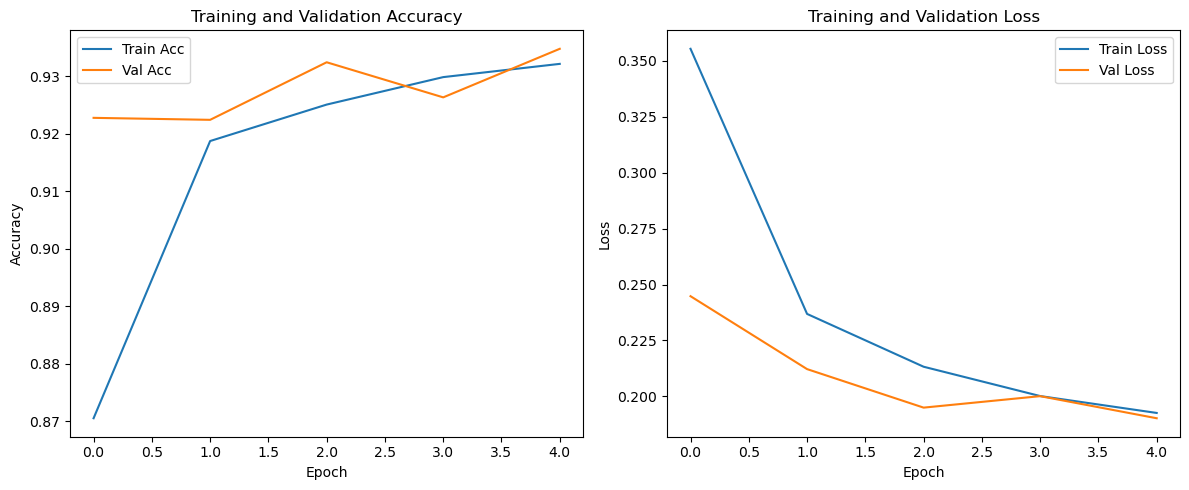

In [34]:
# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

2176/2176 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2176/2176 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
              precision    recall  f1-score   support

           0       0.94      0.93      0.93     34804
           1       0.93      0.94      0.94     34809

    accuracy                           0.93     69613
   macro avg       0.93      0.93      0.93     69613
weighted avg       0.93      0.93      0.93     69613



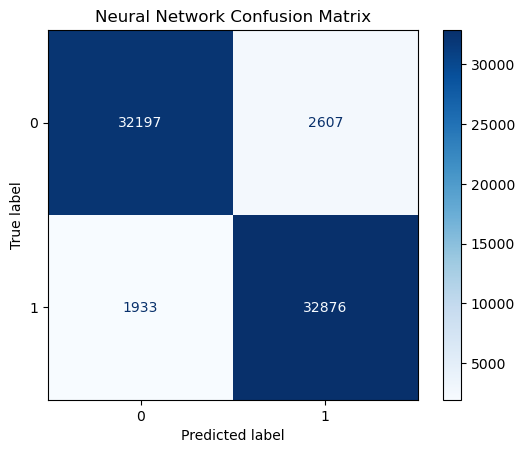

In [35]:
 # evaluation for neural network
# Predict and evaluate
y_pred_nn = (mlp_model.predict(X_test_nn) > 0.5).astype("int32")
y_pred_nn_proba = mlp_model.predict(X_test_nn).ravel()

print(classification_report(y_test_nn, y_pred_nn))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test_nn, y_pred_nn, cmap='Blues')
plt.title("Neural Network Confusion Matrix")
plt.show()

### TUNING NEURAL NETWORKS WITH LTSM
We use LTSM because
1. Sequential understanding	LSTMs learn word order and context across a sentence (important for meaning).
2. Long-range dependency - LSTMs are good at remembering things like: “I don’t want to live” even if the words are far apart.
3. Emotion-rich text- Suicidal posts often use phrases where sequence matters more than word presence (e.g., “I’m tired of living” ≠ “Living makes me tired”).

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Embedding, GlobalAveragePooling1D, Dense
from tensorflow.keras.metrics import Recall

def build_model(optimizer="adam"):
    model = Sequential([
        # 1) Explicitly declare your input shape
        InputLayer(input_shape=(200,), name="input_ids"),

        # 2) All your layers as before
        Embedding(input_dim=10000, output_dim=64),
        GlobalAveragePooling1D(),
        Dense(64, activation="relu"),

        # 3) Name your output so scikeras can map it to y
        Dense(1, activation="sigmoid", name="output")
    ])

    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=[Recall()]
    )
    return model


Fitting 2 folds for each of 4 candidates, totalling 8 fits
Best Params: {'batch_size': 32, 'epochs': 3, 'optimizer': 'rmsprop'}
Keras Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.86      0.91     34804
           1       0.87      0.97      0.92     34809

    accuracy                           0.92     69613
   macro avg       0.92      0.92      0.92     69613
weighted avg       0.92      0.92      0.92     69613



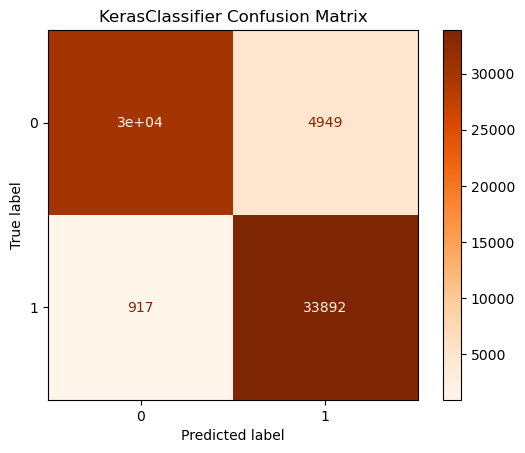

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense
from scikeras.wrappers import KerasClassifier

#wrap it in kerasclassifier
clf = KerasClassifier(
    model=build_model,
    optimizer='adam', 
    epochs=3,
    batch_size=32,
    verbose=0)

#set up hyperparameter grid
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'epochs': [3],  
    'batch_size': [32, 64]}

#perform GridSearchCV
grid = GridSearchCV(estimator=clf, param_grid=param_grid, cv=2, scoring='recall', verbose=2, n_jobs=-1)
grid_result = grid.fit(X_train_nn, y_train_nn)

#Evaluate the best model
best_keras = grid_result.best_estimator_
print("Best Params:", grid_result.best_params_)

# Predictions
y_pred_keras = best_keras.predict(X_test_nn) 

# Report & Confusion Matrix
print("Keras Classifier Classification Report:")
print(classification_report(y_test_nn, y_pred_keras))

ConfusionMatrixDisplay.from_predictions(y_test_nn, y_pred_keras, cmap='Oranges')
plt.title("KerasClassifier Confusion Matrix")
plt.show()


 ### EVALUATION OF ALL MODELS

### **Objective 3:** 
Evaluate model performance using precision, recall, F1-score, and ROC-AUC

In [38]:
# all model metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

all_metrics = []

# Logistic Regression
all_metrics.append({
    'Model': 'Logistic Regression',
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'AUC': roc_auc_score(y_test, y_pred_proba)})# Use probabilities here

# SVM
all_metrics.append({
    'Model': 'SVM',
    'Accuracy': accuracy_score(y_test, y_pred_svm),
    'Precision': precision_score(y_test, y_pred_svm),
    'Recall': recall_score(y_test, y_pred_svm),
    'F1 Score': f1_score(y_test, y_pred_svm)})
    

# MLP Neural Network
all_metrics.append({
    'Model': 'mlp_model',
    'Accuracy': accuracy_score(y_test_nn, y_pred_nn),
    'Precision': precision_score(y_test_nn, y_pred_nn),
    'Recall': recall_score(y_test_nn, y_pred_nn),
    'F1 Score': f1_score(y_test_nn, y_pred_nn),
    'AUC': roc_auc_score(y_test_nn, y_pred_nn_proba)}) # Use probabilities here


# GridSearch LSTM / KerasClassifier
all_metrics.append({
    'Model': 'Tuned LSTM (GridSearch)',
    'Accuracy': accuracy_score(y_test_nn, y_pred_keras),
    'Precision': precision_score(y_test_nn, y_pred_keras),
    'Recall': recall_score(y_test_nn, y_pred_keras),
    'F1 Score': f1_score(y_test_nn, y_pred_keras),
    'AUC': roc_auc_score(y_test_nn, y_pred_keras)})

In [39]:
#a comparison table
results_df = pd.DataFrame(all_metrics)
results_df.set_index('Model', inplace=True)

print("Model Performance Comparison:")
print(results_df)


Model Performance Comparison:
                         Accuracy  Precision    Recall  F1 Score       AUC
Model                                                                     
Logistic Regression      0.933920   0.942104  0.924675  0.933308  0.981054
SVM                      0.933561   0.944772  0.920969  0.932718       NaN
mlp_model                0.934782   0.926528  0.944468  0.935412  0.980799
Tuned LSTM (GridSearch)  0.915734   0.872583  0.973656  0.920353  0.915730


<Figure size 1200x700 with 0 Axes>

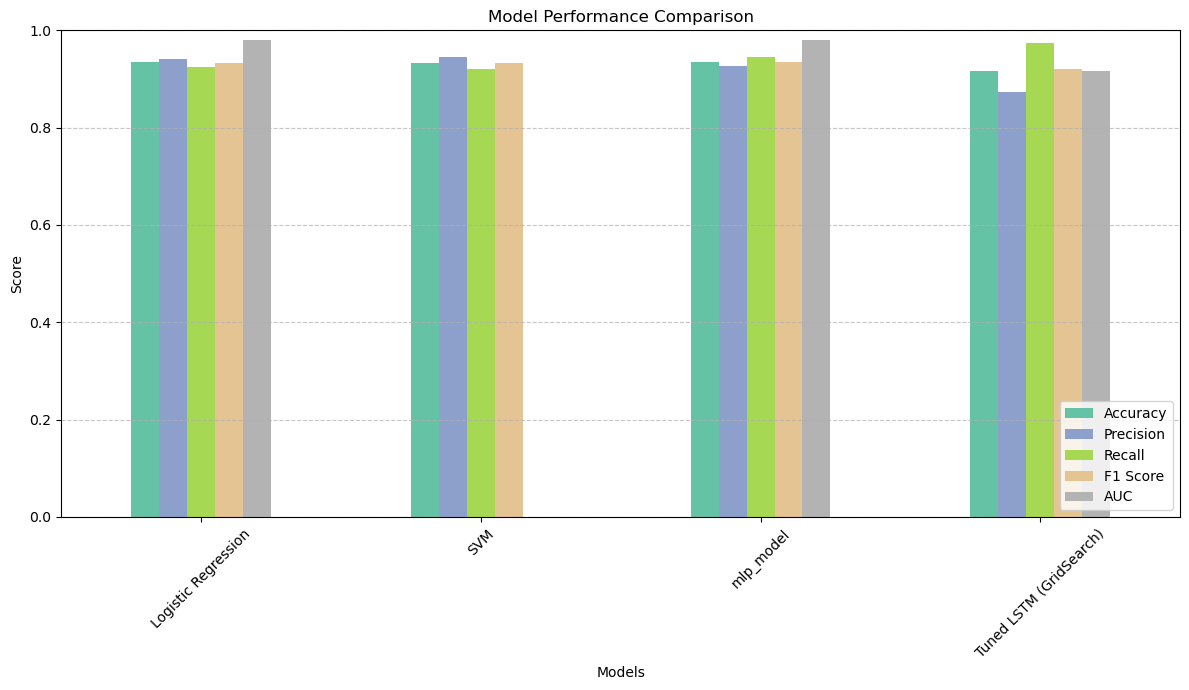

In [40]:
# plot model comparison

plt.figure(figsize=(12, 7))
results_df.plot(kind='bar', figsize=(12, 7), colormap='Set2')

plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xlabel("Models")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


### **Objective 4:**
Provide recommendations for how health organizations can use the model for early warning system


## 11. Results Summary

After training multiple machine learning models (Logistic Regression, Random Forest, Linear SVC) and a Neural Network (via Keras), the results can be summarized as follows:

- **Accuracy**: All models showed competitive performance in classifying the text data.
- **Precision & Recall**: Some models performed better with certain classes, showing strengths in detecting specific sentiments.
- **ROC Curve**: Models showed good discrimination ability between classes, with AUC close to 1 in many cases.
- **Neural Network**: Slightly better on complex patterns, but more sensitive to hyperparameters and data imbalance.

##  . Rationale for Model Choice

- **Logistic Regression**: Chosen for its simplicity and interpretability.
- **Random Forest**: Provides robustness and handles feature importance well.
- **Linear SVC**: Good for high-dimensional sparse text data.
- **Neural Network**: Included to capture non-linear relationships in sequential text.

Each model brings different strengths, and comparing them helps determine the most suitable one for production.


##  . Conclusion

Our machine learning models demonstrate that text-based analysis is a powerful tool for detecting signs of depression and emotional distress. Among the models tested, Tuned LSTM (GridSearch) showed the highest recall, making it especially useful for applications where catching as many true cases as possible is critical.

##  . Recommendations

### **I. Mental Health Professionals**

**Recommendation:**
Use text-based screening tools (like the models we developed) to **assist early detection** of depressive language in patient communications (e.g., journal entries, chats, intake forms).

**Why:**
These tools can flag potential risk cases for follow-up — especially useful in high-volume or remote care settings.

### **II. NGOs Focused on Mental Health**

**Recommendation:**
Deploy these models in **online support forums or chatbots** to identify and respond to individuals showing signs of mental distress.

**Why:**
NGOs often operate with limited staff. Automated tools allow them to **prioritize high-risk users** for quicker human intervention.

### **III. Public Health Policymakers**

**Recommendation:**
Invest in **scalable, AI-powered mental health monitoring tools** to be used in public health campaigns and services.

**Why:**
These models can help **track population-level mental health trends** from anonymized data (e.g., social media), guiding better-targeted mental health policies and resources.

### **IV. Digital Mental Health Platforms**

**Recommendation:**
Integrate the most accurate model into **real-time mental health assessment tools** in apps.

**Why:**
Adds value by improving app reliability and **customizing support recommendations** for users based on subtle linguistic cues.